<a href="https://colab.research.google.com/github/AashiDutt/Pytorch/blob/master/Image_Recognition_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this repository we will look through Image Recognition using Pytorch using MNIST dataset and using validation datset.

softmax activation function capable of dealing with multiclass datasets

## MNIST dataset is input to neural network in form of pixels i.e(28 X 28 = 784 pixels).

1. Therefore our input nodes of neural network must be equal to 784 nodes.

2.while the output classify numbers between 0 to 9 therefore no. of output nodes = 10

## Split large dataset into training and test dataset
  
 **Generalization** - the ability to correctly classify data which has never been seen before and has no labels.
  
he more minimized the training error the greater will be the test error
  
 small training error = underfitting
  
 gap between test and training error grows larger = overfitting
  
** Underfitting** - model with insufficient capacity are unable to solve complex tasks.

**Overfitting **- when model performs better on train data than test data
  
**Reducing overfitting **
1. Reduce depth and complexity of model
2. reduce no. of nodes
3. reduce no. of epochs

**Generalization error** (also known as the out-of-sample error) is a measure of how accurately an algorithm is able to predict outcome values for previously unseen data.
  
**Regularization** - helps to reduce Generalization error.

In [1]:
# CODE

# Loading Images and Transforms

!pip3 install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms

# transformations are used to preprocess the dataset before it is fed to neural network
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#Compose allows us to chain together transformations

#we chose value 0.5 because we want values in range 0 to 1,creating a range (-1 to 1)

# Normalizing the image 
# formula z = (x - mean)/ standard deviation
# eg. (min value - mean)/standard deviation = (0-0.5)/0.5 = -1
# (max value- mean)/sd = (1-0.5)/0.5 =1  therefore range = (-1,1)

#Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) = Normalize(mean,standard deviation)
#Normalize the value of each tensor of image size channel height and widthin 1st set of brackets
#converts numpy array(of range 0-255) to tensor (a float tensor in range 0 to 1)

# defining root directory of training_dataset
training_dataset = datasets.MNIST(root ='./data', train = True, download = True,transform =transform )
validation_dataset = datasets.MNIST(root ='./data', train = False, download = True,transform =transform )
print("Length: ", len(validation_dataset.test_data))

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader =torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = False)

  0%|          | 16384/9912422 [00:00<01:15, 131025.02it/s]

9920512it [00:00, 29542987.27it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 432123.23it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6794709.99it/s]                           
8192it [00:00, 163964.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Length:  10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [0]:
# to plot an image convert it again to a numpy array
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  # clone to create new copy of tensor
  # use detach function to call numpy
  
  image = image.transpose(1,2,0)
  # we have shape of tensor as(1,28,28)(single colorchannel,shape(28,28)) but to plot a grayscale image we need tensor of shape (28,28,1)
  # we swap axis using transpose means swap axis 0 for axis 1, axis 1 fo axis 2 and axis 0 in the end
  #print(image.shape)
  # denormalizing the image
  # x=z * standard deviation + mean
  
  image = image *np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  # to reconvert range from (-1,1) to (1,1) we use clip function
  return image


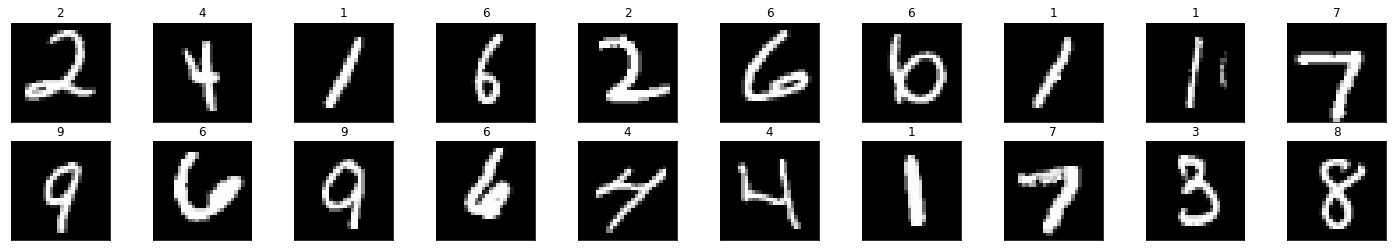

In [5]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(training_loader)
images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class Classifier(nn.Module): # classifying layer by layer
  def __init__(self, D_in , H1,H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in,H1)
    self.linear2 = nn.Linear(H1,H2)
    self.linear3 = nn.Linear(H2,D_out)
  
  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x
  

In [7]:
model = Classifier(784, 125,65,10)  # classifier(no. of pixels that must be fed at input, no. of nodes at hidden layer 1,no. of nodes at hidden layer2,output size = no. of classes 0 to9)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9540, acc 75.5433 
validation loss: 0.4431, validation acc 87.9833 
epoch : 2
training loss: 0.3776, acc 89.3683 
validation loss: 0.3325, validation acc 90.4900 
epoch : 3
training loss: 0.3163, acc 90.7983 
validation loss: 0.3001, validation acc 91.2667 
epoch : 4
training loss: 0.2841, acc 91.7217 
validation loss: 0.2669, validation acc 92.2283 
epoch : 5
training loss: 0.2588, acc 92.3950 
validation loss: 0.2442, validation acc 92.8167 
epoch : 6
training loss: 0.2376, acc 93.0950 
validation loss: 0.2324, validation acc 93.1250 
epoch : 7
training loss: 0.2193, acc 93.6933 
validation loss: 0.2046, validation acc 94.1417 
epoch : 8
training loss: 0.2034, acc 94.1717 
validation loss: 0.1946, validation acc 94.5067 
epoch : 9
training loss: 0.1889, acc 94.5967 
validation loss: 0.1773, validation acc 94.9467 
epoch : 10
training loss: 0.1759, acc 94.9167 
validation loss: 0.1676, validation acc 95.2617 
epoch : 11
training loss: 0.1643, acc 95.2900 
va

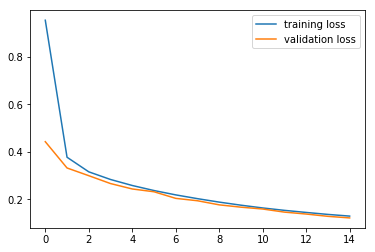

In [10]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label= 'validation loss')
plt.legend()

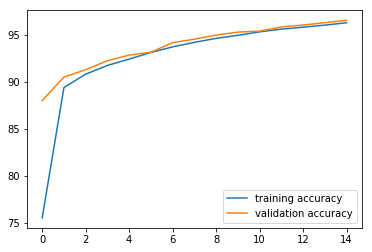

In [11]:
plt.plot(running_corrects_history ,label ='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:

import PIL.ImageOps

<Response [200]>


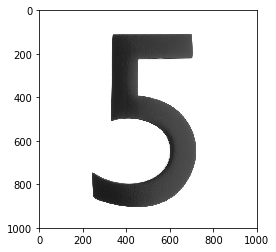

In [13]:
import requests
from PIL import Image
url ='https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

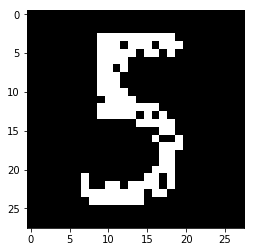

In [14]:
# the model is trained on black background and white image
# above image is reverse ..converting above image to desired form

img = PIL.ImageOps.invert(img)
img = img.convert('1')
img =transform(img)
plt.imshow(im_convert(img))

In [15]:
img = img.view(img.shape[0], -1)
output = model(img)
_,pred = torch.max(output, 1)
print(pred.item())

5


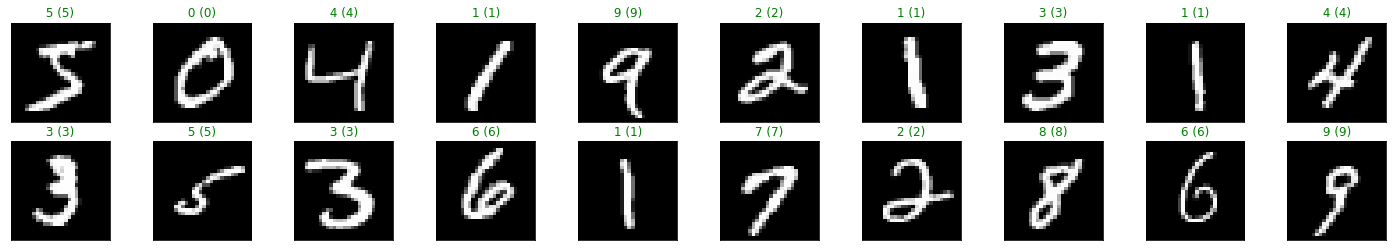

In [16]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(validation_loader)
images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
images_ = images.view(images.shape[0] ,-1)

output = model(images_)
_,preds = torch.max(output, 1)


fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(" {} ({}) ".format(str(preds[idx].item()),str(labels[idx].item())), color= "green" if preds[idx]==labels[idx] else "red")

In [0]:
# saving model

torch.save(model.state_dict(), 'mnist.pth')

In [0]:
# convert pytorch model to tensorflow model using OONX

# STEP 1 - export trained model to oonx

from torch.autograd import Variable

#X_test = np.random.randn(len(validation_dataset.test_data), 784).astype(np.float32)
#print("Actual: ", X_test[0].shape)
#print("Reshaped: ", X_test[0].reshape(1, -1).shape)

# Load the trained model from file
trained_model = Classifier(784, 125,65,10)
trained_model.load_state_dict(torch.load('mnist.pth'))

# Export the trained model to ONNX
dummy_input = Variable(torch.randn(1, 784)) # one black and white 28 x 28 picture will be the input to the model
torch.onnx.export(trained_model,dummy_input, "mnist.onnx")

In [19]:
!pip3 install onnx
!pip3 install onnx-tf

     |████████████████████████████████| 7.1MB 2.8MB/s 
     |████████████████████████████████| 81kB 3.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/a7/ca/b93a3a72d634bbe0030d043bb9b846e70b039806a020bb6ba8
Successfully built onnx-tf


In [20]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
model = onnx.load('mnist.onnx')

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

W0708 15:26:24.762934 140509790529408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/onnx_tf/handlers/backend/ceil.py:10: The name tf.ceil is deprecated. Please use tf.math.ceil instead.

W0708 15:26:24.769683 140509790529408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/onnx_tf/handlers/backend/depth_to_space.py:12: The name tf.depth_to_space is deprecated. Please use tf.compat.v1.depth_to_space instead.

W0708 15:26:27.460662 140509790529408 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0708 15:26:27.464477 140509790529408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/onnx_tf

In [21]:
# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

inputs: ['input.1']
outputs: ['11']
tensor_dict:
{'linear1.bias': <tf.Tensor 'Const:0' shape=(125,) dtype=float32>, 'linear1.weight': <tf.Tensor 'Const_1:0' shape=(125, 784) dtype=float32>, 'linear2.bias': <tf.Tensor 'Const_2:0' shape=(65,) dtype=float32>, 'linear2.weight': <tf.Tensor 'Const_3:0' shape=(65, 125) dtype=float32>, 'linear3.bias': <tf.Tensor 'Const_4:0' shape=(10,) dtype=float32>, 'linear3.weight': <tf.Tensor 'Const_5:0' shape=(10, 65) dtype=float32>, 'input.1': <tf.Tensor 'input.1:0' shape=(1, 784) dtype=float32>, '7': <tf.Tensor 'add:0' shape=(1, 125) dtype=float32>, '8': <tf.Tensor 'Relu:0' shape=(1, 125) dtype=float32>, '9': <tf.Tensor 'add_1:0' shape=(1, 65) dtype=float32>, '10': <tf.Tensor 'Relu_1:0' shape=(1, 65) dtype=float32>, '11': <tf.Tensor 'add_2:0' shape=(1, 10) dtype=float32>}


In [0]:
tf_rep.export_graph('mnist.pb')

In [0]:
from tensorflow.python.tools import freeze_graph, optimize_for_inference_lib

In [0]:
import tensorflow as tf

# Input Graph Definition
input_graph_def = tf.GraphDef()

In [0]:
# Optimize Frozen Model for Inference
# Open "frozen_linear_regression.pb" model
with tf.gfile.Open('mnist.pb', 'rb') as f:
    # Read data from frozen model file
    data = f.read()
    # Parse model data from "data"
    input_graph_def.ParseFromString(data)

In [26]:
output_graph_def = optimize_for_inference_lib.optimize_for_inference(input_graph_def=input_graph_def,
                                                                     input_node_names=["input.1"],
                                                                     output_node_names=['add'],
                                                                     placeholder_type_enum=tf.float32.as_datatype_enum)

W0708 15:26:40.664036 140509790529408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/strip_unused_lib.py:86: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0708 15:26:40.671449 140509790529408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/optimize_for_inference_lib.py:113: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


In [27]:
file = tf.gfile.FastGFile(name="optimized_mnist_model.pb",
                          mode='w')

W0708 15:26:43.318973 140509790529408 deprecation.py:323] From <ipython-input-27-5a31a5c25665>:2: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


In [28]:
# Save the optimized graph def as an optimized frozen model
file.write(file_content=output_graph_def.SerializeToString())

print("Optimized Model Saved at ./optimized_mnist_model.pb")

Optimized Model Saved at ./optimized_mnist_model.pb


In [0]:
# Convert Frozen Model to TFLite Model
converter = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file="mnist.pb",
                                                      input_arrays=["input.1"],
                                                      output_arrays=['add'],
                                                      input_shapes={'input.1': [1, 784]})

In [30]:
# Quantize Trained Model
converter.post_training_quantize = True

# Convert Frozen Model to TFLite Model
tflite_model = converter.convert()

# Save TFLite Model
open("optimized_mnist_model.tflite", "wb").write(tflite_model)

print("Optimized TFLite Model Saved at optimized_mnist_model.tflite")

/usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/lite.py:769: UserWarning: Property post_training_quantize is deprecated, please use optimizations=[Optimize.DEFAULT] instead.
  " instead." % name)


Optimized TFLite Model Saved at optimized_mnist_model.tflite
